### Imports and Config

In [2]:
# OS and fileworks
import os
import ntpath
import csv
import h5py
import pickle
pickle.HIGHEST_PROTOCOL = 4  # for compability reasons

# Data analysis
import numpy as np
import pandas as pd

# Working with dataset
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import MinMaxScaler

# Audio works
from pydub import AudioSegment
from pydub.silence import detect_leading_silence
import librosa

# Visualisation
import librosa.display as lbd
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [90]:
# Dataset Pathways
DATA_PATH = 'dataset/'
SAMPLES_PATH = 'samples/'

### Audio Loading and Processing Functions

In [91]:
def trim_silence(sound, s_thresh=-28.0):
    '''Trims silent chunks from beginning and end of the sound'''
    duration = len(sound)
    
    start_trim = detect_leading_silence(sound, s_thresh)
    end_trim = detect_leading_silence(sound.reverse(), s_thresh)
    
    start = start_trim if start_trim != duration else None
    end = duration - end_trim if end_trim != duration else None
    
    return sound[start:end]

In [92]:
def normalize_volume(sound, target_dBFS=-20.0):
    '''Normalizes sound and shifts to specified loudness'''
    sound = sound.normalize()
    difference = target_dBFS - sound.dBFS
    return sound.apply_gain(difference)

In [171]:
def read_mp3(file, sample_rate=22050, duration=None, normalized=False):
    '''Reads MP3-file to numpy array'''
    # Load mp3 file as pydub AudioSegment
    a = AudioSegment.from_mp3(file)
    # Convert to mono mode with the desired sample rate
    a = a.set_channels(1).set_frame_rate(sample_rate)
    # Normalize audio volume
    a = normalize_volume(a)
    # Trim by removing silence from beginning and end of the sound
    a = trim_silence(a)
    # Cut to the desired duration
    if duration:
        a = a[:duration * 1000]
    
    # Convert the AudioSegment to signal in form of numpy.array
    y = np.array(a.get_array_of_samples(), dtype='float')
    # Normalize if specified
    if normalized:
        y /= np.linalg.norm(y)
    return y, sample_rate

### Extraction Functions

#### Features
Get the means and variances of the features:
- Top 13 MFCC (Mel Frequency Cepstral Coefficients)
- Delta MFCC and Delta-delta MFCC
- Spectral Centroid / Spectral Roll-off

In [127]:
sr = 22050        # sample frame rate
duration = 5      # dample duration

n_mfcc = 13       # number of MFCCs to extract from each sample
n_mels = 128      # number of mels

n_fft = 2048      # length of the FFT window
hop_length = 512  # number of samples between successive frames

delta_width = 9   # MFCC Delta parameter

In [290]:
def obtain_features(y, sr=22050, duration=5, delta_width=9):
    '''Extracts sound features from given signal and returns them as a numpy array'''
    # --- MFCC (returns M: np.ndarray [shape=(n_mfcc, t)])
    mfcc = librosa.feature.mfcc(y, sr, 
                                n_mfcc=n_mfcc, n_mels=n_mels, 
                                n_fft=n_fft, hop_length=hop_length)
    
    # --- Delta-MFCC / Delta-delta-MFCC
    mfcc_len = mfcc.shape[1]
    dw = max(3, int(np.ceil(mfcc_len) // 2 * 2 - 1)) if mfcc_len < delta_width else delta_width
    mfcc_delta1 = librosa.feature.delta(mfcc, width=dw, order=1)
    mfcc_delta2 = librosa.feature.delta(mfcc, width=dw, order=2)
    
    # --- Spectral Centroid / Spectral Roll-off
    spectr_c = librosa.feature.spectral_centroid(y, sr)
    spectr_r = librosa.feature.spectral_rolloff(y, sr)
    
    return mfcc, mfcc_delta1, mfcc_delta2, spectr_c, spectr_r

In [129]:
def create_features_array(mfcc, mfcc_delta1, mfcc_delta2, spectr_c, spectr_r):
    '''Creates wholistic numpy array of means and variances out of given features'''
    make_meanvar = lambda m, v: [item for t in zip(m, v) for item in t]

    mean_var_ops = [
        (mfcc.mean(axis=1), mfcc.var(axis=1)), 
        (mfcc_delta1.mean(axis=1), mfcc_delta1.var(axis=1)), 
        (mfcc_delta2.mean(axis=1), mfcc_delta2.var(axis=1))
    ]

    mfcc_meanvars = sum([make_meanvar(m, v) 
                         for m, v in mean_var_ops], [])
    
    spectr_meanvars = [spectr_c.mean(), spectr_c.var(), 
                       spectr_r.mean(), spectr_r.var()]
    
    return mfcc_meanvars + spectr_meanvars

In [130]:
def get_features(y, sr=22050, duration=5, delta_width=9):
    '''Returns numpy array of sound features obtained from signal'''
    return create_features_array(*obtain_features(y, sr, duration, delta_width))

In [3374]:
%%timeit

get_features(y, sr)

19.1 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
# Define helper func for creating columns layout list
def create_columns_list():
    make_columns_str = lambda prefix: [
        f'{prefix}_{i}{sfx}' 
        for i in range(1, 14) 
        for sfx in ('_mean', '_var')
    ]
    cols1 = make_columns_str('mfcc')
    cols2 = make_columns_str('mfcc_delta1')
    cols3 = make_columns_str('mfcc_delta2')
    cols4 = ['spectral_centroid_mean', 'spectral_centroid_var', 
             'spectral_rolloff_mean', 'spectral_rolloff_var']
    return sum([['path'], cols1, cols2, cols3, cols4], [])


cl = create_columns_list()
print(f'{len(cl)} columns in total:\n')
print(cl)

83 columns in total:

['path', 'mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'mfcc_delta1_1_mean', 'mfcc_delta1_1_var', 'mfcc_delta1_2_mean', 'mfcc_delta1_2_var', 'mfcc_delta1_3_mean', 'mfcc_delta1_3_var', 'mfcc_delta1_4_mean', 'mfcc_delta1_4_var', 'mfcc_delta1_5_mean', 'mfcc_delta1_5_var', 'mfcc_delta1_6_mean', 'mfcc_delta1_6_var', 'mfcc_delta1_7_mean', 'mfcc_delta1_7_var', 'mfcc_delta1_8_mean', 'mfcc_delta1_8_var', 'mfcc_delta1_9_mean', 'mfcc_delta1_9_var', 'mfcc_delta1_10_mean', 'mfcc_delta1_10_var', 'mfcc_delta1_11_mean', 'mfcc_delta1_11_var', 'mfcc_delta1_12_mean', 'mfcc_delta1_12_var', 'mfcc_delta1_13_mean', 'mfcc_delta1_13_var', 'mfcc_delta2_1_me

In [133]:
# Single-row example
pd.DataFrame([['test.mp3'] + [*get_features(y, sr)]],
             columns=create_columns_list())

,path,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
0,test.mp3,-579.546899,7405.077305,97.965905,5003.18782,20.203955,1396.818397,25.061901,638.393504,1.88377,...,-0.006779,0.9115,0.032163,1.237376,0.001333,0.662596,2231.81071,3.062229e+06,3792.485555,6.999884e+06


##### DataFrame

In [141]:
cols = create_columns_list()

filenames = np.empty((0, 1), 'O')
features = np.empty((0, len(cols) - 1))

for i in range(10):
    row_filename = [mp3list[i]]
    print(f'{i}: {row_filename[0]}')
    y, sr = read_mp3(DATA_PATH + SAMPLES_PATH + row_filename[0], 
                     duration=5, normalized=False)
    
    filenames = np.append(filenames, [row_filename], axis=0)
    features = np.append(features, [get_features(y, sr)], axis=0)

0: common_voice_en_1027059.mp3
1: common_voice_en_21788001.mp3
2: common_voice_en_21788002.mp3
3: common_voice_en_21788003.mp3
4: common_voice_en_21788004.mp3
5: common_voice_en_17712231.mp3
6: common_voice_en_20560595.mp3
7: common_voice_en_20560597.mp3
8: common_voice_en_20560598.mp3
9: common_voice_en_20560599.mp3


In [142]:
features.shape

(10, 82)

In [3360]:
pd.DataFrame(np.hstack([filenames, features]), 
             columns=cols).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   path                    10 non-null     object
 1   mfcc_1_mean             10 non-null     object
 2   mfcc_1_var              10 non-null     object
 3   mfcc_2_mean             10 non-null     object
 4   mfcc_2_var              10 non-null     object
 5   mfcc_3_mean             10 non-null     object
 6   mfcc_3_var              10 non-null     object
 7   mfcc_4_mean             10 non-null     object
 8   mfcc_4_var              10 non-null     object
 9   mfcc_5_mean             10 non-null     object
 10  mfcc_5_var              10 non-null     object
 11  mfcc_6_mean             10 non-null     object
 12  mfcc_6_var              10 non-null     object
 13  mfcc_7_mean             10 non-null     object
 14  mfcc_7_var              10 non-null     object
 15  mfcc_8_me

In [3369]:
features_df = pd.DataFrame(np.hstack([filenames, features]), 
                           columns=cols)
features_df[cols[1:]] = features_df[cols[1:]].astype('float32', copy=False)

features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   path                    10 non-null     object 
 1   mfcc_1_mean             10 non-null     float32
 2   mfcc_1_var              10 non-null     float32
 3   mfcc_2_mean             10 non-null     float32
 4   mfcc_2_var              10 non-null     float32
 5   mfcc_3_mean             10 non-null     float32
 6   mfcc_3_var              10 non-null     float32
 7   mfcc_4_mean             10 non-null     float32
 8   mfcc_4_var              10 non-null     float32
 9   mfcc_5_mean             10 non-null     float32
 10  mfcc_5_var              10 non-null     float32
 11  mfcc_6_mean             10 non-null     float32
 12  mfcc_6_var              10 non-null     float32
 13  mfcc_7_mean             10 non-null     float32
 14  mfcc_7_var              10 non-null     float

In [143]:
# Define helper func for creating features dataframe
def make_features_df(filenames, features, cols):
    df = pd.DataFrame(np.hstack([filenames, features]), 
                      columns=cols)
    df[cols[1:]] = df[cols[1:]].astype('float32', copy=False)
    return df

features_df = make_features_df(filenames, features, cols)
features_df

,path,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
0,common_voice_en_1027059.mp3,751.021301,3148.276123,85.950974,3876.465332,40.381245,514.134766,39.890297,1015.176453,46.019722,...,-0.055177,2.719417,-0.062086,1.524860,0.059113,1.738826,2379.839844,3.942263e+06,4522.421387,11102860.00
1,common_voice_en_21788001.mp3,723.617188,17813.816406,104.258942,4735.208008,-14.275517,927.059265,22.438845,1238.508301,-6.717800,...,0.044790,1.176524,-0.077606,1.128868,-0.040173,2.029362,2166.185059,1.367848e+06,4064.491699,4092307.00
2,common_voice_en_21788002.mp3,766.730225,11248.207031,99.007248,6158.422852,-11.298870,1093.534790,30.018774,1135.959839,-15.870113,...,0.023673,1.936473,-0.007529,1.970771,0.006999,0.962176,2400.978516,2.438994e+06,4094.997070,5364243.00
3,common_voice_en_21788003.mp3,753.593933,12834.445312,124.075768,3735.942627,-14.024351,938.283630,36.517948,1500.675903,-7.659095,...,-0.050289,1.410707,0.039971,2.066693,0.050266,1.747302,1916.960449,1.364674e+06,3633.827637,3473885.00
4,common_voice_en_21788004.mp3,734.726746,15816.260742,112.910034,4367.609863,-29.355175,1003.748901,40.602444,1795.745117,9.057791,...,0.005383,1.687249,-0.051856,1.820237,0.021869,1.615883,1923.202637,8.282684e+05,3583.533691,2413910.50
5,common_voice_en_17712231.mp3,692.032166,12640.898438,130.306732,3007.211670,11.551091,3768.447998,61.407192,1375.702637,22.595474,...,0.026155,1.926239,0.077790,2.191497,-0.019565,1.620740,1121.161743,1.037461e+06,2072.027100,3263043.25
6,common_voice_en_20560595.mp3,820.223145,10724.212891,75.881950,8351.405273,-15.415523,1598.966064,14.461582,1146.324951,1.945999,...,0.034688,2.517703,-0.025977,1.579080,-0.069280,2.733870,2958.244873,3.454616e+06,5009.336426,7469237.00
7,common_voice_en_20560597.mp3,806.380493,10874.972656,109.879456,7272.663086,9.972621,1687.539307,17.420595,801.010498,-2.950832,...,0.150017,2.291064,-0.077748,1.243397,-0.012659,2.258896,2510.841797,4.004000e+06,4295.187012,9235856.00
8,common_voice_en_20560598.mp3,796.475281,15419.111328,101.856140,6762.932129,-5.837375,1980.896973,17.472122,670.150452,-7.895182,...,0.049005,1.601511,-0.041836,1.668567,0.002883,1.551677,2567.953857,3.052582e+06,4535.946289,8142622.50
9,common_voice_en_20560599.mp3,832.566162,12907.895508,106.564468,4931.681152,-6.969711,1438.843506,22.284252,614.604126,10.715459,...,0.005034,2.008352,0.027493,1.456792,0.094842,1.370834,2469.698975,3.039516e+06,4509.434570,7173465.00


In [3145]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   filename                10 non-null     string 
 1   mfcc_1_mean             10 non-null     float32
 2   mfcc_1_var              10 non-null     float32
 3   mfcc_2_mean             10 non-null     float32
 4   mfcc_2_var              10 non-null     float32
 5   mfcc_3_mean             10 non-null     float32
 6   mfcc_3_var              10 non-null     float32
 7   mfcc_4_mean             10 non-null     float32
 8   mfcc_4_var              10 non-null     float32
 9   mfcc_5_mean             10 non-null     float32
 10  mfcc_5_var              10 non-null     float32
 11  mfcc_6_mean             10 non-null     float32
 12  mfcc_6_var              10 non-null     float32
 13  mfcc_7_mean             10 non-null     float32
 14  mfcc_7_var              10 non-null     float

In [3371]:
features_df.describe()

,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,mfcc_5_var,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01
mean,617.168701,13642.345703,105.988724,6672.645508,1.147790,1404.251831,30.741764,1187.709595,7.792452,682.189575,...,0.011223,1.555975,0.005712,1.329211,-0.010596,1.422537,2241.506592,2.453022e+06,4032.120361,6.173143e+06
std,38.133209,3810.964355,12.660870,2323.793213,19.345816,725.948303,12.589671,379.205658,18.205498,175.259827,...,0.030332,0.359325,0.013892,0.165245,0.017332,0.187098,500.772278,1.217280e+06,813.296021,2.888913e+06
min,558.933350,4822.526855,77.770851,3342.223877,-21.281422,619.014099,16.419220,662.784363,-12.793940,398.321930,...,-0.023250,1.185029,-0.015094,1.089980,-0.038651,1.196241,1121.161743,8.282684e+05,2072.027100,2.413910e+06
25%,594.105103,12114.587158,100.691973,5320.688354,-10.490550,1000.044785,20.694146,934.158295,-4.115484,628.800217,...,-0.011603,1.264732,-0.003569,1.172298,-0.019874,1.299101,1983.948242,1.365467e+06,3741.493652,3.628490e+06
50%,610.653564,14655.543945,107.775715,6127.701660,-5.163876,1212.322754,26.527122,1203.399048,2.390418,704.335022,...,0.006507,1.376849,0.000398,1.396493,-0.013886,1.359389,2390.409180,2.739255e+06,4195.092041,6.268854e+06
75%,643.552261,15176.628906,112.422277,8682.958740,10.048740,1518.667938,38.771049,1332.417084,12.309973,748.832489,...,0.016814,1.831452,0.018705,1.447784,0.000383,1.527013,2500.556091,3.354107e+06,4519.174683,7.974276e+06
max,679.366089,19112.892578,124.668449,10310.162109,45.166370,3235.021973,54.981945,1876.733887,49.608944,1030.776001,...,0.071098,2.143317,0.025970,1.547122,0.023166,1.782938,2958.244873,4.004000e+06,5009.336426,1.110286e+07


In [144]:
# Helper func to normalize the features dataframe
def normalize_features_df(df):
    # apply MinMax Normalization
    norm_cols = df.columns[1:]
    df[norm_cols] = MinMaxScaler().fit_transform(df[norm_cols])
    # return dataframe with the new scaled data
    return df

In [3148]:
# new data frame with the new scaled data
df_scaled = normalize_features_df(features_df)
df_scaled

,filename,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
0,common_voice_en_1027059.mp3,0.419750,0.000000,0.185008,0.162654,1.000000,0.000000,0.541663,0.339140,1.000000,...,0.000000,1.000000,0.100695,0.372653,0.782302,0.438366,0.685150,0.980560,0.834231,1.000000
1,common_voice_en_21788001.mp3,0.224750,1.000000,0.521398,0.323341,0.216238,0.126885,0.169926,0.528222,0.147881,...,0.487182,0.000000,0.000911,0.000000,0.177345,0.602354,0.568849,0.169907,0.678330,0.193164
2,common_voice_en_21788002.mp3,0.531530,0.552310,0.424904,0.589651,0.258922,0.178041,0.331388,0.441400,0.000000,...,0.384272,0.492548,0.451457,0.792283,0.464768,0.000000,0.696657,0.507198,0.688715,0.339550
3,common_voice_en_21788003.mp3,0.438056,0.660471,0.885512,0.136359,0.219840,0.130334,0.469828,0.750183,0.132672,...,0.023822,0.151782,0.756851,0.882551,0.728394,0.443150,0.433186,0.168908,0.531711,0.121991
4,common_voice_en_21788004.mp3,0.303802,0.863793,0.680354,0.254556,0.000000,0.150451,0.556833,1.000000,0.402779,...,0.295136,0.331018,0.166469,0.650622,0.555372,0.368973,0.436584,0.000000,0.514589,0.000000
5,common_voice_en_17712231.mp3,0.000000,0.647274,1.000000,0.000000,0.586584,1.000000,1.000000,0.644376,0.621517,...,0.396366,0.485915,1.000000,1.000000,0.302909,0.371714,0.000000,0.065872,0.000000,0.097726
6,common_voice_en_20560595.mp3,0.912170,0.516581,0.000000,1.000000,0.199891,0.333352,0.000000,0.450176,0.287868,...,0.437951,0.869263,0.332853,0.423678,0.000000,1.000000,1.000000,0.827006,1.000000,0.581811
7,common_voice_en_20560597.mp3,0.813670,0.526861,0.624670,0.798147,0.563949,0.360569,0.063031,0.157819,0.208746,...,1.000000,0.722371,0.000000,0.107779,0.344988,0.731910,0.756460,1.000000,0.756870,0.785129
8,common_voice_en_20560598.mp3,0.743187,0.836712,0.477249,0.702767,0.337238,0.450713,0.064128,0.047028,0.128857,...,0.507723,0.275448,0.230891,0.507890,0.439690,0.332733,0.787549,0.700410,0.838836,0.659310
9,common_voice_en_20560599.mp3,1.000000,0.665480,0.563760,0.360105,0.321001,0.284149,0.166633,0.000000,0.429563,...,0.293433,0.539135,0.676627,0.308596,1.000000,0.230659,0.734064,0.696296,0.829810,0.547771


In [3150]:
df_scaled.describe()

,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,mfcc_5_var,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.538692,0.626948,0.536286,0.432758,0.370366,0.301449,0.336343,0.435834,0.335988,0.437303,...,0.382589,0.486748,0.371675,0.504605,0.479577,0.451986,0.609850,0.511616,0.667309,0.432645
std,0.322830,0.271440,0.296914,0.324874,0.280726,0.279627,0.310462,0.315722,0.295649,0.282933,...,0.279233,0.313771,0.342376,0.327758,0.298629,0.275355,0.272591,0.383307,0.276885,0.332481
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332789,0.533223,0.437990,0.185629,0.217138,0.135363,0.089754,0.203149,0.136474,0.332266,...,0.293859,0.289340,0.117138,0.324611,0.313429,0.341793,0.469650,0.169158,0.568366,0.139784
50%,0.484793,0.653873,0.542579,0.341723,0.289962,0.231095,0.250657,0.445788,0.248307,0.466236,...,0.390319,0.489231,0.281872,0.465784,0.452229,0.405040,0.690904,0.601747,0.722793,0.443660
75%,0.796049,0.793904,0.666433,0.674488,0.507271,0.353765,0.523705,0.615337,0.422867,0.508107,...,0.474874,0.676562,0.620335,0.756868,0.685139,0.562553,0.750861,0.795357,0.833126,0.639935
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Mel Spectrograms

In [145]:
# Helper for padding signal in order to fit it into 5 sec minimum span
p_thresh = int(np.ceil(sr * duration / hop_length))
pad_melspec = lambda s, v: np.pad(s, [(0, 0), (0, max(0, p_thresh - s.shape[1]))], 
                                  constant_values=v)

In [146]:
def get_melspec(y, sr=22050):
    '''Extracts Mel Spectogram from given signal and returns it padded to 5 secs'''
    melspec = librosa.feature.melspectrogram(y, sr, 
                                             n_mels=n_mels, n_fft=n_fft, 
                                             hop_length=hop_length)
    
    melspec = librosa.power_to_db(np.abs(melspec), ref=np.max)
    melspec = pad_melspec(melspec, melspec.min())  # pad with minimum volume value
    return melspec

### Extract Features

In [317]:
def extract_features(source_filename, data_path=DATA_PATH, samples_path=SAMPLES_PATH, 
                     features_filename='features_df.h5', melspecs_filename='melspecs.h5', 
                     sample_rate=22050, duration=5, thresh=None, backup=None):
    '''Performs complex features extraction process'''
    accents_df = pd.read_hdf(data_path + source_filename)
    files = accents_df['path'].values[:thresh]
    features_filename = data_path + features_filename
    melspecs_filename = data_path + melspecs_filename

    files_count = len(files)
    
    cols = create_columns_list()

    # Create containers for filenames and related features
    filenames = np.empty((0, 1), 'O')
    features = np.empty((0, len(cols) - 1))
    
    with h5py.File(melspecs_filename, 'w') as melspecs_save:
        ###=== Calculate features for each audio sample ===###
        for i, file in enumerate(files):
            ipd.clear_output(wait=True)
            
            print(f'Writing MELSPECS into: {melspecs_filename}', 
                  f'(bytes written: {os.path.getsize(melspecs_filename):,})')
            print(f'Extracting FEATURES and MELSPECS for {file} ({i + 1} of {files_count}).. ', end='')
            
            # Read MP3 file and receive signal ['y'] and sample_rate ['sr']
            y, sr = read_mp3(data_path + samples_path + file, 
                             sample_rate, duration, normalized=False)
            
            # Extract and stash FEATURES
            filenames = np.append(filenames, [[file]], axis=0)
            features = np.append(features, [get_features(y, sr)], axis=0)

            # Extract and save MELSPEC
            melspec = get_melspec(y, sr)
            melspecs_save.create_dataset(file, data=melspec, dtype=melspec.dtype, )
#                                          chunks=(1, *melspec.shape[1:]), 
#                                          compression='gzip', compression_opts=9)
    
            print('Done')
        
            ##### BACKUP #####
            if i == backup:
                features_df = make_features_df(filenames, features, cols)
#                 features_df = normalize_features_df(features_df)
                features_df.to_hdf(data_path + features_filename.replace('.', f'_{backup}.'), 
                                   'features_df', mode='w', complevel=9, 
                                   index=False)
                melspecs_save.flush()
                import shutil
                shutil.copyfile(melspecs_filename, 
                                data_path + melspecs_filename.replace('.', f'_{backup}.'))

    # Create pandas dataframe to hold the table of features
    features_df = make_features_df(filenames, features, cols)
    features_df = normalize_features_df(features_df)  # normalize all features to the same scale
    # Export features dataframe to HDF5 storage
    print(f'Writing FEATURES into: {features_filename}', end=' ')
    features_df.to_hdf(features_filename, 'features_df', mode='w', index=False)
    print(f'(bytes written: {os.path.getsize(features_filename):,})')
    print(f'\nSuccessfully processed {i + 1} audiofiles')

In [3451]:
# %%time

extract_features(source_filename='source_df.h5', 
                 features_filename='features_df.h5', melspecs_filename='melspecs.h5', 
                 sample_rate=22050, duration=5, )
#                  thresh=100, backup=50)

Writing MELSPECS into: dataset/melspecs.h5 (bytes written: 70,741,964,944)
Extracting FEATURES and MELSPECS for common_voice_en_666025.mp3 (319257 of 319257).. Done
Writing FEATURES into: dataset/features_df.h5 (bytes written: 222,926,368)

Successfully processed 319257 audiofiles
Wall time: 1d 19h 29min 41s


##### Test Read HDF5 Data

In [1]:
def show_img(img):
    print('shape:', img.shape)
    plt.imshow(img, origin='lower')

total: 100
file: common_voice_en_18404209.mp3
shape: (128, 329)


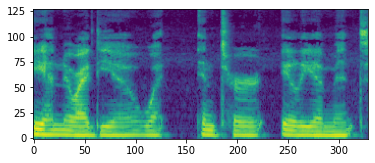

In [3407]:
data_filepath = DATA_PATH + 'melspecs.h5'

with h5py.File(data_filepath, 'r') as loadfile:
    files = list(loadfile.keys())
    print('total:', len(files))
    src = files[10]
    print('file:', src)
    file = loadfile[src]
    show_img(file)

### Additional Datasets

#### Examples

In [389]:
from io import BytesIO
from youtube_dl import YoutubeDL
from urllib.request import urlopen

from proto.examples import EXAMPLES
EXAMPLES

{'Star Wars': {'title': 'Star Wars: Obi-Wan Says "Hello There"',
  'url': 'https://www.youtube.com/watch?v=eaEMSKzqGAg',
  'start': 1.0,
  'accent': 'england'},
 'English 1': {'title': 'Upper-class Accent Examples',
  'url': 'https://www.youtube.com/watch?v=EHgrDDwXkTA',
  'start': 6.0,
  'accent': 'england'},
 'English 2': {'title': 'Natalie Hockham: Machine learning with imbalanced data sets',
  'url': 'https://www.youtube.com/watch?v=X9MZtvvQDR4',
  'start': 0.0,
  'accent': 'england'},
 'Indian 1': {'title': 'Can you understand Indian English Accent?',
  'url': 'https://www.youtube.com/watch?v=eKp7vUffdXM',
  'start': 1.5,
  'accent': 'indian'},
 'Indian 2': {'title': 'The Big Bang Theory S06E06 Indian accent',
  'url': 'https://www.youtube.com/watch?v=QStKveYU9TI',
  'start': 2.0,
  'accent': 'indian'},
 'Indian 3': {'title': 'A Sampling of Indian English Accents',
  'url': 'https://www.youtube.com/watch?v=v9arM_agKFA',
  'start': 14.0,
  'accent': 'indian'},
 'Irish 1': {'title':

In [390]:
examples_df = pd.DataFrame.from_dict(EXAMPLES, orient='index')
examples_df

,title,url,start,accent
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",https://www.youtube.com/watch?v=eaEMSKzqGAg,1.0,england
English 1,Upper-class Accent Examples,https://www.youtube.com/watch?v=EHgrDDwXkTA,6.0,england
English 2,Natalie Hockham: Machine learning with imbalan...,https://www.youtube.com/watch?v=X9MZtvvQDR4,0.0,england
Indian 1,Can you understand Indian English Accent?,https://www.youtube.com/watch?v=eKp7vUffdXM,1.5,indian
Indian 2,The Big Bang Theory S06E06 Indian accent,https://www.youtube.com/watch?v=QStKveYU9TI,2.0,indian
Indian 3,A Sampling of Indian English Accents,https://www.youtube.com/watch?v=v9arM_agKFA,14.0,indian
Irish 1,"Irish Schoolboy With Thick Accent Warns of ""Fr...",https://www.youtube.com/watch?v=pj705DvCSxg,0.0,ireland


In [356]:
def extract_audio(audio_data, start_from=0, duration=5, filepath='test.wav'):
    # Instanciate pydub AudioSegment object from raw audio
    audioObj = AudioSegment.from_file(BytesIO(audio_data))
    
    # Cut to the desired duration
    start = start_from * 1000
    end = start + duration * 1000
    audioObj = audioObj[start:end]

    # Convert AudioSegment to wav format instance
    audioObj.export(filepath, format='wav')

In [412]:
EXAMPLES_PATH = 'additional/Examples/'
EXAMPLES_SAMPLES_PATH = 'samples/'
paths, accents = [], []

for i in range(len(examples_df)):
    row = examples_df.iloc[i]
    url, start_from, sample_name, accent = (row['url'], row['start'], 
                                            row.name, row['accent'])

    with YoutubeDL({'format': 'bestaudio'}) as ydl:
        info = ydl.extract_info(url, download=False)
    print(f'''
               Title: {info['title']}
    Overall Duration: {info['duration']} sec.
          Start from: {start_from}
    ''')
    
    print('Downloading audio..', end='')
    filename = '_'.join(sample_name.split()).lower()
    filepath = f'{EXAMPLES_PATH + EXAMPLES_SAMPLES_PATH}{filename}.wav'
    audio_data = urlopen(info['url']).read()
    extract_audio(audio_data, start_from, filepath=DATA_PATH + filepath)
    print('success\n')
    paths.append(filepath)
    accents.append(accent)

[youtube] eaEMSKzqGAg: Downloading webpage

               Title: Obi-Wan Says Hello There
    Overall Duration: 2 sec.
          Start from: 1.0
    

[youtube] EHgrDDwXkTA: Downloading webpage

               Title: Upper-class Accent Examples
    Overall Duration: 197 sec.
          Start from: 6.0
    

[youtube] X9MZtvvQDR4: Downloading webpage

               Title: Natalie Hockham: Machine learning with imbalanced data sets
    Overall Duration: 1665 sec.
          Start from: 0.0
    

[youtube] eKp7vUffdXM: Downloading webpage

               Title: Can you understand Indian English Accent? : Funny Video
    Overall Duration: 26 sec.
          Start from: 1.5
    

[youtube] QStKveYU9TI: Downloading webpage

               Title: The Big Bang Theory S06E06 Indian accent
    Overall Duration: 140 sec.
          Start from: 2.0
    

[youtube] v9arM_agKFA: Downloading webpage

               Title: A Sampling of Indian English Accents
    Overall Duration: 698 sec.
          Sta

In [401]:
examples_df['path'] = paths
examples_df['accent'] = accents
examples_df

,title,url,start,path,accent
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",https://www.youtube.com/watch?v=eaEMSKzqGAg,1.0,additional/Examples/star_wars.wav,england
English 1,Upper-class Accent Examples,https://www.youtube.com/watch?v=EHgrDDwXkTA,6.0,additional/Examples/english_1.wav,england
English 2,Natalie Hockham: Machine learning with imbalan...,https://www.youtube.com/watch?v=X9MZtvvQDR4,0.0,additional/Examples/english_2.wav,england
Indian 1,Can you understand Indian English Accent?,https://www.youtube.com/watch?v=eKp7vUffdXM,1.5,additional/Examples/indian_1.wav,indian
Indian 2,The Big Bang Theory S06E06 Indian accent,https://www.youtube.com/watch?v=QStKveYU9TI,2.0,additional/Examples/indian_2.wav,indian
Indian 3,A Sampling of Indian English Accents,https://www.youtube.com/watch?v=v9arM_agKFA,14.0,additional/Examples/indian_3.wav,indian
Irish 1,"Irish Schoolboy With Thick Accent Warns of ""Fr...",https://www.youtube.com/watch?v=pj705DvCSxg,0.0,additional/Examples/irish_1.wav,ireland


In [408]:
examples_df.to_hdf(DATA_PATH + EXAMPLES_PATH + 'examples_df.h5', 
                   'examples_df', mode='w', index=False)

In [414]:
%%time

# Extract features for Examples dataset
extract_features(source_filename=EXAMPLES_PATH + 'examples_df.h5', samples_path='', 
                 features_filename='examples_features_df.h5', melspecs_filename='examples_melspecs.h5', 
                 sample_rate=22050, duration=5)

Writing MELSPECS into: dataset/examples_melspecs.h5 (bytes written: 1,332,616)
Extracting FEATURES and MELSPECS for additional/Examples/irish_1.wav (7 of 7).. Done
Writing FEATURES into: dataset/examples_features_df.h5 (bytes written: 1,071,032)

Successfully processed 7 audiofiles
Wall time: 840 ms


#### AccentsDB

In [176]:
ACCENTSDB_PATH = 'additional/accentdb/data/'

cv_accents_mapping = {
    'us': ['american'], 
    'england': ['british', 'welsh'], 
    'australia': ['australian'], 
    'indian': ['bangla', 'indian', 'malayalam', 'odiya', 'telugu']
}
map_accent = lambda ac: [k for k, v in cv_accents_mapping.items() if ac in v][0]

accentsdb_list = []
for ac in os.listdir(DATA_PATH + ACCENTSDB_PATH):
    path = DATA_PATH + ACCENTSDB_PATH + ac + '/'
    for s_id in os.listdir(path):
        for file in os.listdir(path + s_id):
            dirpath = path[33:] + s_id
            filepath = dirpath + '/' + file
            speaker = f'{ac}_{s_id}'
            accent = map_accent(ac)
            accentsdb_list.append((filepath, speaker, accent))
        print('Processed:', dirpath)

Processed: american/speaker_01
Processed: american/speaker_02
Processed: american/speaker_03
Processed: american/speaker_04
Processed: american/speaker_05
Processed: american/speaker_06
Processed: american/speaker_07
Processed: american/speaker_08
Processed: australian/speaker_01
Processed: australian/speaker_02
Processed: bangla/speaker_01
Processed: bangla/speaker_02
Processed: british/speaker_01
Processed: british/speaker_02
Processed: indian/speaker_01
Processed: indian/speaker_02
Processed: malayalam/speaker_01
Processed: malayalam/speaker_02
Processed: malayalam/speaker_03
Processed: odiya/speaker_01
Processed: telugu/speaker_01
Processed: telugu/speaker_02
Processed: welsh/speaker_01


In [178]:
accentsdb_df = pd.DataFrame(accentsdb_list, columns=['path', 'speaker', 'accent'])
accentsdb_df

,path,speaker,accent
0,american/speaker_01/american_s01_001.wav,american_speaker_01,us
1,american/speaker_01/american_s01_002.wav,american_speaker_01,us
2,american/speaker_01/american_s01_003.wav,american_speaker_01,us
3,american/speaker_01/american_s01_004.wav,american_speaker_01,us
4,american/speaker_01/american_s01_005.wav,american_speaker_01,us
...,...,...,...
17308,welsh/speaker_01/welsh_s01_738.wav,welsh_speaker_01,england
17309,welsh/speaker_01/welsh_s01_739.wav,welsh_speaker_01,england
17310,welsh/speaker_01/welsh_s01_740.wav,welsh_speaker_01,england
17311,welsh/speaker_01/welsh_s01_741.wav,welsh_speaker_01,england


In [175]:
accentsdb_df['accent'].value_counts()

indian       7667
us           5936
england      2226
australia    1484
Name: accent, dtype: int64

In [159]:
accentsdb_h5_name = 'accentsdb_df.h5'

In [160]:
accentsdb_df.to_hdf(DATA_PATH + accentsdb_h5_name, 
                    'accentsdb_df', mode='w', index=False)

shape = f'{accentsdb_df.shape[0]} rows, {accentsdb_df.shape[1]} columns'
print(f'Successfully written AccentsDB samples dataset to: {new_h5_name} ({shape})')

Successfully written AccentsDB samples dataset to: accentsdb_df.h5 (17313 rows, 2 columns)


In [409]:
%%time

# Extract features for AccentDB dataset
extract_features(source_filename=ACCENTSDB_PATH + 'accentsdb_df.h5', samples_path=ACCENTSDB_PATH, 
                 features_filename='accentsdb_features_df.h5', melspecs_filename='accentsdb_melspecs.h5', 
                 sample_rate=22050, duration=5)

Writing MELSPECS into: dataset/accentsdb_melspecs.h5 (bytes written: 79,776,664)
Extracting FEATURES and MELSPECS for american/speaker_01/american_s01_361.wav (361 of 17313).. 

KeyboardInterrupt: 

#### VoxCeleb

In [438]:
VOXCELEB_PATH = 'additional/VoxCeleb/'
VOXCELEB_SAMPLES_PATH = 'samples/'

In [439]:
import pandas as pd
voxceleb_df = pd.read_csv(DATA_PATH + VOXCELEB_PATH + 'vox1_meta.csv', sep='\t')
voxceleb_df['Nationality'].value_counts()

USA                    799
UK                     215
Canada                  54
Australia               37
India                   26
Norway                  20
Ireland                 18
Germany                  9
New Zealand              8
Italy                    8
Mexico                   7
Sweden                   5
Russia                   4
Spain                    4
Switzerland              3
Denmark                  3
Netherlands              3
Chile                    3
Philippines              3
Croatia                  3
Poland                   2
China                    2
Portugal                 2
South Africa             1
Austria                  1
Pakistan                 1
France                   1
South Korea              1
Iran                     1
Israel                   1
Sudan                    1
Singapore                1
Sri Lanka                1
Brazil                   1
Guyana                   1
Trinidad and Tobago      1
Name: Nationality, dtype: in

In [441]:
voxceleb_to_commonvoice_map = {
    'USA': 'us', 'UK': 'england', 'India': 'indian', 
    'Australia': 'australia', 'Canada': 'canada', 
    'Ireland': 'ireland', 'New Zealand': 'newzealand', 
    'South Africa': 'african', 'Philippines': 'philippines', 
    'Singapore': 'singapore', 'China': 'hongkong'
}

gender_map = {
    'm': 'male', 
    'f': 'female'
}

In [442]:
voxceleb_df = voxceleb_df[voxceleb_df['Nationality'].isin(voxceleb_to_commonvoice_map.keys())]
voxceleb_df

,VoxCeleb1 ID,VGGFace1 ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev
...,...,...,...,...,...
1246,id11247,Zachary_Levi,m,USA,dev
1247,id11248,Zachary_Quinto,m,USA,dev
1248,id11249,Zack_Snyder,m,USA,dev
1249,id11250,Zoe_Saldana,f,USA,dev


In [451]:
voxceleb_list = []

for i in range(len(voxceleb_df)):
    row = voxceleb_df.iloc[i]
    s_id, speaker, gender, nationality = (row['VoxCeleb1 ID'], row['VGGFace1 ID'], 
                                          row['Gender'], row['Nationality'])
    
    path = VOXCELEB_PATH + VOXCELEB_SAMPLES_PATH + s_id
    youtube_ids = os.listdir(DATA_PATH + path)
    for yt in youtube_ids:
        yt_dirpath = path + '/' + yt
        for file in os.listdir(DATA_PATH + yt_dirpath):
            filepath = yt_dirpath + '/' + file
            new_speaker = f'[{nationality}]_{speaker}'
            new_gender = gender_map[gender]
            accent = voxceleb_to_commonvoice_map[nationality]
            voxceleb_list.append((filepath, new_speaker, new_gender, accent))
    print('Processed:', s_id)

Processed: id10001
Processed: id10002
Processed: id10003
Processed: id10004
Processed: id10005
Processed: id10006
Processed: id10007
Processed: id10008
Processed: id10009
Processed: id10010
Processed: id10011
Processed: id10012
Processed: id10013
Processed: id10014
Processed: id10015
Processed: id10016
Processed: id10017
Processed: id10018
Processed: id10020
Processed: id10021
Processed: id10022
Processed: id10023
Processed: id10025
Processed: id10026
Processed: id10027
Processed: id10028
Processed: id10029
Processed: id10032
Processed: id10033
Processed: id10034
Processed: id10035
Processed: id10036
Processed: id10038
Processed: id10039
Processed: id10040
Processed: id10041
Processed: id10042
Processed: id10043
Processed: id10044
Processed: id10045
Processed: id10046
Processed: id10047
Processed: id10048
Processed: id10049
Processed: id10050
Processed: id10051
Processed: id10052
Processed: id10053
Processed: id10054
Processed: id10055
Processed: id10056
Processed: id10057
Processed: i

Processed: id10494
Processed: id10495
Processed: id10496
Processed: id10497
Processed: id10498
Processed: id10499
Processed: id10500
Processed: id10501
Processed: id10502
Processed: id10503
Processed: id10504
Processed: id10505
Processed: id10506
Processed: id10507
Processed: id10508
Processed: id10509
Processed: id10510
Processed: id10512
Processed: id10513
Processed: id10514
Processed: id10515
Processed: id10516
Processed: id10518
Processed: id10519
Processed: id10520
Processed: id10521
Processed: id10522
Processed: id10523
Processed: id10524
Processed: id10525
Processed: id10526
Processed: id10527
Processed: id10528
Processed: id10529
Processed: id10530
Processed: id10531
Processed: id10532
Processed: id10533
Processed: id10534
Processed: id10535
Processed: id10536
Processed: id10537
Processed: id10538
Processed: id10539
Processed: id10540
Processed: id10541
Processed: id10542
Processed: id10543
Processed: id10544
Processed: id10545
Processed: id10546
Processed: id10547
Processed: i

Processed: id10971
Processed: id10972
Processed: id10973
Processed: id10974
Processed: id10975
Processed: id10976
Processed: id10977
Processed: id10978
Processed: id10979
Processed: id10980
Processed: id10981
Processed: id10982
Processed: id10983
Processed: id10984
Processed: id10985
Processed: id10986
Processed: id10987
Processed: id10988
Processed: id10989
Processed: id10990
Processed: id10991
Processed: id10992
Processed: id10993
Processed: id10994
Processed: id10995
Processed: id10996
Processed: id10997
Processed: id10998
Processed: id10999
Processed: id11000
Processed: id11001
Processed: id11002
Processed: id11003
Processed: id11004
Processed: id11005
Processed: id11006
Processed: id11007
Processed: id11008
Processed: id11009
Processed: id11010
Processed: id11011
Processed: id11012
Processed: id11013
Processed: id11015
Processed: id11016
Processed: id11017
Processed: id11018
Processed: id11019
Processed: id11020
Processed: id11021
Processed: id11022
Processed: id11023
Processed: i

In [453]:
voxceleb_df = pd.DataFrame(voxceleb_list, columns=['path', 'speaker', 'gender', 'accent'])
voxceleb_df

,path,speaker,gender,accent
0,additional/VoxCeleb/samples/id10001/1zcIwhmdeo...,[Ireland]_A.J._Buckley,male,ireland
1,additional/VoxCeleb/samples/id10001/1zcIwhmdeo...,[Ireland]_A.J._Buckley,male,ireland
2,additional/VoxCeleb/samples/id10001/1zcIwhmdeo...,[Ireland]_A.J._Buckley,male,ireland
3,additional/VoxCeleb/samples/id10001/7gWzIy6yII...,[Ireland]_A.J._Buckley,male,ireland
4,additional/VoxCeleb/samples/id10001/7gWzIy6yII...,[Ireland]_A.J._Buckley,male,ireland
...,...,...,...,...
143363,additional/VoxCeleb/samples/id11251/Tmh87G_cDZ...,[USA]_Zulay_Henao,female,us
143364,additional/VoxCeleb/samples/id11251/WbB8m9-wlI...,[USA]_Zulay_Henao,female,us
143365,additional/VoxCeleb/samples/id11251/WbB8m9-wlI...,[USA]_Zulay_Henao,female,us
143366,additional/VoxCeleb/samples/id11251/XHCSVYEZvl...,[USA]_Zulay_Henao,female,us


In [457]:
voxceleb_df.accent.value_counts()

us             94871
england        27773
canada          5602
indian          5469
australia       4593
ireland         2567
newzealand      1307
philippines      487
hongkong         376
african          261
singapore         62
Name: accent, dtype: int64

In [465]:
voxceleb_df_h5_name = 'voxceleb_df.h5'

In [466]:
voxceleb_df.to_hdf(DATA_PATH + voxceleb_df_h5_name, 
                         'voxceleb_df_small', mode='w', index=False)

shape = f'{voxceleb_df.shape[0]} rows, {voxceleb_df.shape[1]} columns'
print(f'Successfully written VoxCeleb_Small samples dataset to: {voxceleb_df_h5_name} ({shape})')

Successfully written VoxCeleb_Small samples dataset to: voxceleb_df.h5 (143368 rows, 4 columns)


In [459]:
accents_thresh = 2000

voxceleb_df_small = pd.DataFrame(columns=voxceleb_df.columns)
for accent in voxceleb_df.accent.unique():
    sl = voxceleb_df[voxceleb_df['accent'] == accent][:accents_thresh]
    voxceleb_df_small = voxceleb_df_small.append(sl)
    
voxceleb_df_small.accent.value_counts()

canada         2000
us             2000
ireland        2000
england        2000
australia      2000
indian         2000
newzealand     1307
philippines     487
hongkong        376
african         261
singapore        62
Name: accent, dtype: int64

In [460]:
voxceleb_df_small_h5_name = 'voxceleb_df_small.h5'

In [461]:
voxceleb_df_small.to_hdf(DATA_PATH + voxceleb_df_small_h5_name, 
                         'voxceleb_df_small', mode='w', index=False)

shape = f'{voxceleb_df_small.shape[0]} rows, {voxceleb_df_small.shape[1]} columns'
print(f'Successfully written VoxCeleb_Small samples dataset to: {voxceleb_df_small_h5_name} ({shape})')

Successfully written VoxCeleb_Small samples dataset to: voxceleb_df_small.h5 (14493 rows, 4 columns)


In [463]:
%%time

# Extract features for VoxCeleb dataset
extract_features(source_filename=VOXCELEB_PATH + 'voxceleb_df_small.h5', samples_path='', 
                 features_filename='voxceleb_small_features_df.h5', 
                 melspecs_filename='voxceleb_small_melspecs.h5', 
                 sample_rate=22050, duration=5)

Writing MELSPECS into: dataset/voxceleb_small_melspecs.h5 (bytes written: 3,212,556,296)
Extracting FEATURES and MELSPECS for additional/VoxCeleb/samples/id11075/ZS3RlkEFFXU/00002.wav (14493 of 14493).. Done
Writing FEATURES into: dataset/voxceleb_small_features_df.h5 (bytes written: 11,555,608)

Successfully processed 14493 audiofiles
Wall time: 16min 29s


### [ Old Experiments ]

#### NumPy memmap

In [32]:
# Extract MEL SPECTROGRAMS: memmap
def extract_melspecs_memmap(accents_filename, melspecs_filename, sample_rate=22050, duration=5):
    melspecs_filepath = DATA_PATH + '/' + melspecs_filename
    accents_df = pd.read_csv(DATA_PATH + accents_filename)
    files = accents_df['path'].values[:1000]

    data_sample = obtain_melspec(files[0], sample_rate, duration)
    files_count = len(files)
    savefile = np.memmap(melspecs_filepath, 
                         dtype=data_sample.dtype, 
                         mode='w+', 
                         shape=(files_count, *data_sample.shape))
                         
    for i, file in enumerate(files):
        ipd.clear_output(wait=True)
        print(f'Writing into: {melspecs_filepath}')
        print(f'Extracting MELSPECs for {file} ({i + 1} of {files_count}).. ', end='')
        savefile[i] = obtain_melspec(file, sample_rate, duration)
        print('Done')

    print(f'Successfully extracted {i + 1} MELSPECs')
    print(f'Total bytes written: {os.path.getsize(melspecs_filepath):,}')

In [33]:
%%time
extract_melspecs_memmap('train-accents.csv', 'melspecs_train_MEMMAP.npy')

Writing into: dataset//melspecs_train_MEMMAP.npy
Extracting MELSPECs for common_voice_en_23400334.mp3 (1000 of 1000).. Done
Successfully extracted 1000 MELSPECs
Total bytes written: 110,592,000
Wall time: 3min 22s


In [58]:
data_filepath = DATA_PATH + 'melspecs_train_MEMMAP.npy'
data_shape = (128, 216)

loadfile = np.memmap(data_filepath, 
                     dtype=np.float32, 
                     mode='c', 
                     shape=(1000, *data_shape))

#### NPZ Stream

In [40]:
# Extract MEL SPECTROGRAMS and STREAM them to a solid numpy-array NPZ file
# https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html
def extract_melspecs_stream(accents_filename, melspecs_filename, sample_rate=22050, duration=5):
    melspecs_filepath = DATA_PATH + '/' + melspecs_filename
    accents_df = pd.read_csv(DATA_PATH + accents_filename)
    files = accents_df['path'].values[:10]

    files_count = len(files)
    with open(melspecs_filepath, 'wb') as savefile:
        for i, file in enumerate(files):
            ipd.clear_output(wait=True)
            print(f'Writing into: {melspecs_filepath}')
            print(f'Total bytes written: {os.path.getsize(melspecs_filepath):,}')
            print(f'Extracting MELSPECs for {file} ({i + 1} of {files_count}).. ', end='')
            melspec = obtain_melspec(file, sample_rate, duration)

            np.save(savefile, melspec)
#             np.savez_compressed(savefile, **{file: melspec})
            print('Done')

    print(f'Successfully extracted {i + 1} MELSPECs')

In [41]:
%time extract_melspecs_stream('train-accents.csv', 'melspecs_train_STREAM.npz')

Writing into: dataset/melspecs_train_STREAM.npz
Total bytes written: 996,480
Extracting MELSPECs for common_voice_en_20560599.mp3 (10 of 10).. <class 'numpy.ndarray'> float32
Done
Successfully extracted 10 MELSPECs
Wall time: 3.5 s


In [11]:
# %timeit os.path.getsize(DATA_PATH + 'melspecs_train_STREAM.npz')

31.5 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
# Extract MEL SPECTROGRAMS as a solid numpy-array NPZ file
def extract_melspecs(accents_filename, melspecs_filename, sample_rate=22050, duration=5):
    accents_df = pd.read_csv(DATA_PATH + accents_filename)
    files = accents_df['filename'].values
    
    melspecs = deque()
    files_count = len(files)
    for i, file in enumerate(files):
        ipd.clear_output(wait=True)
        print(f'Extracting MELSPECs for {file} ({i + 1} of {files_count}).. ', end='')
        melspec = obtain_melspec(file, sample_rate, duration)
        melspecs.append(melspec)
        print('Done')

    np.savez_compressed(DATA_PATH + melspecs_filename, melspecs=melspecs)
    print(f'Successfully written {i + 1} MELSPECs into: {melspecs_filename}')

In [182]:
extract_melspecs('cv-valid-train-accents.csv', 'melspecs_train.npz')

Extracting MELSPECs for cv-valid-train/sample-195774.mp3 (64711 of 64711).. Done
Successfully written 64711 MELSPECs into: melspecs_train.npz


In [ ]:
extract_melspecs('cv-valid-test-accents.csv', 'melspecs_test.npz')

In [39]:
# Extract MEL SPECTROGRAMS as separate numpy-array NPZ files
def extract_melspecs_sep(accents_filename, target_dir='melspecs/', sample_rate=22050, duration=5):
    accents_df = pd.read_csv(DATA_PATH + accents_filename)
    files = accents_df['filename'].values
    
    save_dir_melspecs = DATA_PATH + target_dir
    if not os.path.exists(save_dir_melspecs):
        os.mkdir(save_dir_melspecs)
    
    files_count = len(files)
    for i, file in enumerate(files):
        ipd.clear_output(wait=True)
        print(f'Extracting MELSPECs for {file} ({i + 1} of {files_count}).. ', end='')
        melspec = obtain_melspec(file, sample_rate, duration)
        np.savez_compressed(f'{save_dir_melspecs}melspec_{get_filename(file)}.npz', melspec)
        print('Done')
    
    print(f'Successfully extracted {i + 1} MELSPECs to: {save_dir_melspecs}')

#### Make Extractions

In [43]:
%time extract_melspecs_sep('cv-valid-train-accents.csv', target_dir='melspecs-train/')

Extracting MELSPECs for cv-valid-train/sample-195774.mp3 (64711 of 64711).. Done
Successfully extracted 64711 MELSPECs to: dataset_small/melspecs-train/


In [42]:
%time extract_melspecs_sep('cv-valid-dev-accents.csv', target_dir='melspecs-dev/')

Extracting MELSPECs for cv-valid-dev/sample-004073.mp3 (1350 of 1350).. Done
Successfully extracted 1350 MELSPECs to: dataset_small/melspecs-dev/


In [41]:
%time extract_melspecs_sep('cv-valid-test-accents.csv', target_dir='melspecs-test/')

Extracting MELSPECs for cv-valid-test/sample-003989.mp3 (1338 of 1338).. Done
Successfully extracted 1338 MELSPECs to: dataset_small/melspecs-test/


In [51]:
%time extract_melspecs_sep('train-accents.csv')

Extracting MELSPECs for common_voice_en_22130889.mp3 (316953 of 316953).. Done
Successfully extracted 316953 MELSPECs to: dataset/melspecs/
Wall time: 1d 4h 23min 3s


In [12]:
extract_melspecs_sep('dev-accents.csv')

Extracting MELSPECs for common_voice_en_82206.mp3 (1863 of 1863).. Done
Successfully extracted 1863 MELSPECs to: dataset/melspecs/


In [16]:
extract_melspecs_sep('test-accents.csv')

Extracting MELSPECs for common_voice_en_666025.mp3 (1483 of 1483).. Done
Successfully extracted 1483 MELSPECs to: dataset/melspecs/
